In [10]:
# Data stuffs
import pickle 
import numpy as np
import pandas as pd
from operator import itemgetter

# Plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from moxie.data.utils_ import load_data

# Scipy stuffs 
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.stats import truncnorm, norm 
from scipy import signal 

# Fancy 
from tqdm.notebook import tqdm  

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [12]:
# Load Data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle', elm_timings=False)
# profiles, mps, masks, psis, rmids, trainids, uncerts
train_ids, val_ids, test_ids = np.array(train_data[-2]), np.array(val_data[-2]), np.array(test_data[-2])

# ELM TIMINGS PER DATASET
with open('../../data/processed/new_elm_timings_idxs.pickle', 'rb') as file: 
    GLOBAL_ELM_TIMING_DICT = pickle.load(file) 

# Pulse ids is a list of lists that corresponds to the indexes in the dataset to take.
train_new_pulse_idxs, train_elm_percentages = itemgetter('pulse_idx', 'elm_percentages')(GLOBAL_ELM_TIMING_DICT['train'])
val_new_pulse_idxs, val_elm_percentages = itemgetter('pulse_idx', 'elm_percentages')(GLOBAL_ELM_TIMING_DICT['val'])
test_new_pulse_idxs, test_elm_percentages = itemgetter('pulse_idx', 'elm_percentages')(GLOBAL_ELM_TIMING_DICT['test'])

def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

# Get the ordering of pulses for each dataset. To be used in conjunction with the for the  
train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses_ordered_set = unique(train_pulse_order)

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses_ordered_set = unique(val_pulse_order)

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses_ordered_set = unique(test_pulse_order)

# JET PDB 
machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]

In [96]:
# boilerplate stuff
import math
from collections.abc import Iterable

def get_nearest_weighted_idx(query, data, sort=True):
    if sort:
        unsorted = np.array(data)
        sortidx = np.argsort(data)
        sort_reverse = {i: sortidx[i] for i in range(len(data))}

        data = np.array(data)[sortidx]
    data = list(data)
    if query in data: # exact match
        idx = [(1, data.index(query))] # weight, index
    elif query < data[0]: # before first
        idx = [(1, 0)] 
    elif query > data[-1]: # after last
        idx = [(1, len(data)-1)]
    else:
        # get nearest two elements
        i_r = np.searchsorted(data, query)
        i_l = i_r - 1
        dist = data[i_r] - query + query - data[i_l]
        idx = [(1-(data[i_r] - query)/dist, i_r), (1-(query - data[i_l])/dist, i_l)]

    # convert back to unsorted idx
    if sort:
        idx = [(w, sort_reverse[i]) for (w, i) in idx]
    return idx
class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

def get_pedestal_top_for_slice(p_old, x, plot_result=False):
        # standardize signal
        p = standardize_signal(p_old, trim_zeros=True)
        
        # interp signal to Nx=50
        f_interp = interpolate.interp1d(x, p)
        x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
        p_h = f_interp(x_h)

        # smooth with savgol filter
        p_s = savgol_filter(p_h, window_length=11, polyorder=3)

        # get max gradient so we're in the pedestal
        p_s_grad = np.gradient(p_s)
        min_i = np.argmin(p_s_grad)
        
        
        # search from pedestal region outward in 2nd derivatives
        p_s_grad2 = np.gradient(p_s_grad)
        p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
        p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
        # standardize s.t. if we go >1 sd up/down, we stop searching
        
        # go to the left from middle point
        sd_cutoff = -.5
        start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
        min_val = p_s_grad2[min_i]
        top_i = min_i
        for i in reversed(range(0, min_i)):
            if p_s_grad2[i] < min_val:
                min_val = p_s_grad2[i]
                top_i = i
                if min_val < sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] > sd_cutoff:
                break
        
        # found our x for top
        # same procedure for bottom
        sd_cutoff = .5
        start_cut_early = False  # if we go > 1 for x'', etc.
        max_val = p_s_grad2[min_i]
        bottom_i = min_i
        
        for i in range(min_i+1, x_h.shape[0]):
            if p_s_grad2[i] > max_val:
                max_val = p_s_grad2[i]
                bottom_i = i
                if max_val > sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] < sd_cutoff:
                break
        
        top, bottom = x_h[top_i], x_h[bottom_i]        
        if plot_result:
            plt.plot(x_h, p_s)
            plt.plot(x, p)
            plt.axvline(top, color='red')
            plt.axvline(bottom, color='blue')
            plt.show()
        return top, bottom

# Finding $n_{e,sep}$

- Gaussian Filtering 
    - Treat each measurement in the profile time slice as a normal distribution, $\sigma$ = point value, $\mu  =$ uncertainty 
    - Sum the PDF of density around points 100eV
        - Leverages spatial simultaenous capture of measruemnts via HRTS 
        - Assumes two-point model for JET (i.e., $T_{e, sep} \approx 100$ [eV]  
    - Due to the tapering of in edge region of profile, this will probably be much lower than expected. 
        - Need to account for this by only using gaussian filtering on 'relevant points'
            - Can find the pedestal top via smoothing and 1st/2nd derivative 
            - Use points + 2cm away from that
            - If a slice has a determined pedestal top larger or less than 1 std of the mean for the pulse, then use the mean
            
    

In [ ]:
def do_all_pulses(dataset, set_idxs, set_pulse_order, set_elm_percentages, plotting=False): 
    profiles, mps, masks, psis, rmids, names, uncerts = dataset
    
    iterator = tqdm(enumerate(zip(set_idxs, set_pulse_order)), total=len(set_pulse_order))
    
    set_neseps, set_teseps = np.zeros(len(profiles)), np.zeros(len(profiles))
    set_neseps_nc, set_teseps_nc = np.zeros(len(profiles)), np.zeros(len(profiles))
    
    for pulse, (pulse_idxs, pulse_number) in iterator:  
        iterator.set_description_str('{} #SLICES {}'.format(pulse_number, len(pulse_idxs)))
        # if they don't have elm timings we don't give a fuck
        if len(pulse_idxs) == 0: 
            continue
        if pulse_number == 83294: 
            continue
        
        pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks = profiles[pulse_idxs], uncerts[pulse_idxs], rmids[pulse_idxs], masks[pulse_idxs]
        pedestal_tops = find_pedestal_tops(pulse_profs, pulse_rmids, pulse_masks, plotting)
        pulse_neseps, pulse_teseps, pulse_neseps_nc, pulse_teseps_nc = find_neseps(pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks, pedestal_tops, pulse_number, plotting=False, compare=False)
        
        set_neseps[pulse_idxs], set_neseps_nc[pulse_idxs] = pulse_neseps, pulse_neseps_nc
        set_teseps[pulse_idxs], set_teseps_nc[pulse_idxs] = pulse_teseps, pulse_teseps_nc
        # print(pedestal_tops)
        break
    return set_neseps, set_neseps_nc, set_teseps, set_teseps_nc
plt.close('all')

train_nesep_tesep_tuple = do_all_pulses(train_data, train_new_pulse_idxs, train_pulses_ordered_set, train_elm_percentages)
val_nesep_tesep_tuple = do_all_pulses(val_data, val_new_pulse_idxs, val_pulses_ordered_set, val_elm_percentages)
test_nesep_tesep_tuple = do_all_pulses(test_data, test_new_pulse_idxs, test_pulses_ordered_set, test_elm_percentages)
# train_neseps, train_neseps_nc, train_teseps, train_teseps_nc 

In [310]:
def collect_set(dataset, set_idxs, set_pulse_order, set_elm_percentages, set_nesep_tesep_tuple):
    profiles, mps, masks, psis, rmids, names, uncerts = dataset
    
    iterator = tqdm(enumerate(zip(set_idxs, set_pulse_order)), total=len(set_pulse_order))
    
    x_data, target_data, elm_percents, tseps_data = [], [], [], []
    x_data_means, target_means = [], []
    set_neseps, set_neseps_nc, set_teseps, set_teseps_nc = set_nesep_tesep_tuple
    
    for pulse, (pulse_idxs, pulse_number) in iterator:  
        iterator.set_description_str('{} #SLICES {}'.format(pulse_number, len(pulse_idxs)))
        if len(pulse_idxs) == 0: 
            continue
        if pulse_number == 83294: 
            continue
        # pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks = profiles[pulse_idxs], uncerts[pulse_idxs], rmids[pulse_idxs], masks[pulse_idxs]
        pulse_neseps, pulse_mps, pulse_elms, pulse_teseps = set_neseps[pulse_idxs], mps[pulse_idxs], set_elm_percentages[pulse_idxs], set_teseps[pulse_idxs],
        
        not_nans = np.logical_and(np.invert(np.isnan(pulse_neseps)), np.invert(np.isnan(pulse_elms)))
        pulse_neseps, pulse_teseps, pulse_mps, pulse_elms = pulse_neseps[not_nans], pulse_teseps[not_nans],pulse_mps[not_nans], pulse_elms[not_nans]
        
        mean, std = pulse_neseps.mean(), pulse_neseps.std()
        within_cutoff = (abs(pulse_neseps - mean) > std)
        within_cutoff = np.logical_and(within_cutoff, pulse_neseps > 0.0)
                
        pulse_neseps, pulse_teseps, pulse_mps, pulse_elms = pulse_neseps[within_cutoff], pulse_teseps[within_cutoff], pulse_mps[within_cutoff], pulse_elms[within_cutoff]
        
        x_data.append(pulse_mps)
        target_data.extend(pulse_neseps)
        elm_percents.extend(pulse_elms)
        tseps_data.extend(pulse_teseps)
        
        x_data_means.append(pulse_mps.mean(0))
        target_means.append(pulse_neseps.mean())
        
        
    return np.vstack(x_data), np.array(target_data), np.array(elm_percents), np.array(tseps_data), np.vstack(x_data_means), 

train_ins, train_targets, train_elms, train_tseps = collect_set(train_data, train_new_pulse_idxs, train_pulses_ordered_set, train_elm_percentages, train_nesep_tesep_tuple)
val_ins, val_targets, val_elms, val_tseps = collect_set(val_data, val_new_pulse_idxs, val_pulses_ordered_set, val_elm_percentages, val_nesep_tesep_tuple)
test_ins, test_targets, test_elms, test_tseps =  collect_set(test_data, test_new_pulse_idxs, test_pulses_ordered_set, test_elm_percentages, test_nesep_tesep_tuple)

supervised_dict = {'train': {'mps': train_ins, 'targets': train_targets, 'elms': train_elms, 'tseps': train_tseps}, 
                   'val': {'mps': val_ins, 'targets': val_targets, 'elms': val_elms, 'tseps': val_tseps}, 
                    'test': {'mps': test_ins, 'targets': test_targets, 'elms': test_elms, 'tseps': test_tseps},}
with open('../../data/processed/supervised_dataset_130522_v2.pickle', 'wb') as file: 
    pickle.dump(supervised_dict, file) 

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

((290, 13), (290,))

  0%|          | 0/533 [00:00<?, ?it/s]

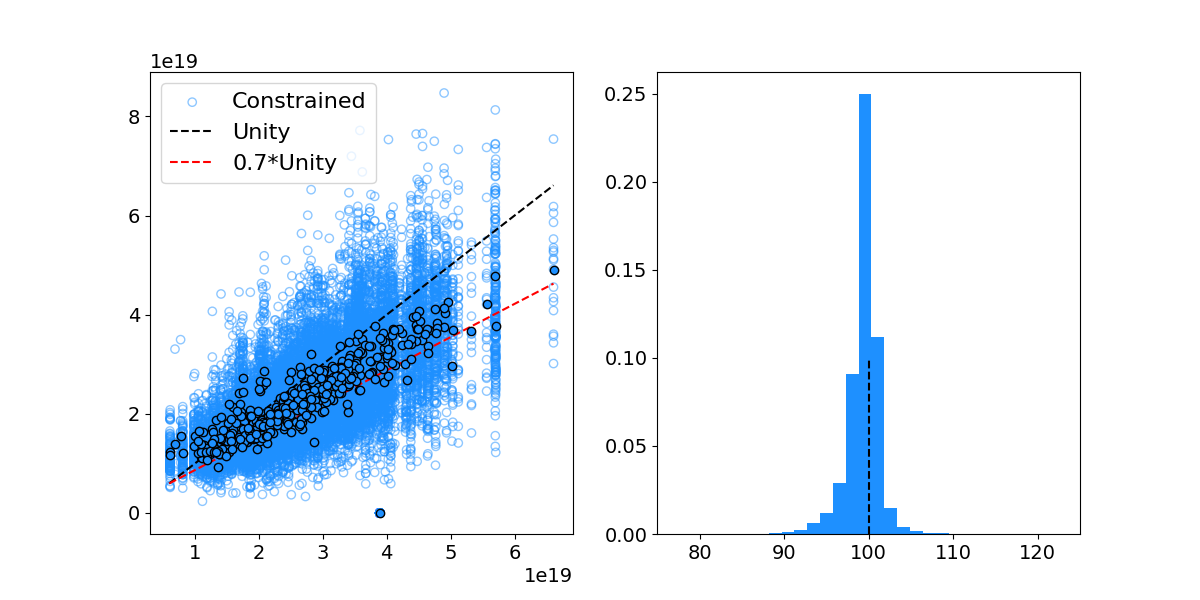

  0%|          | 0/133 [00:00<?, ?it/s]

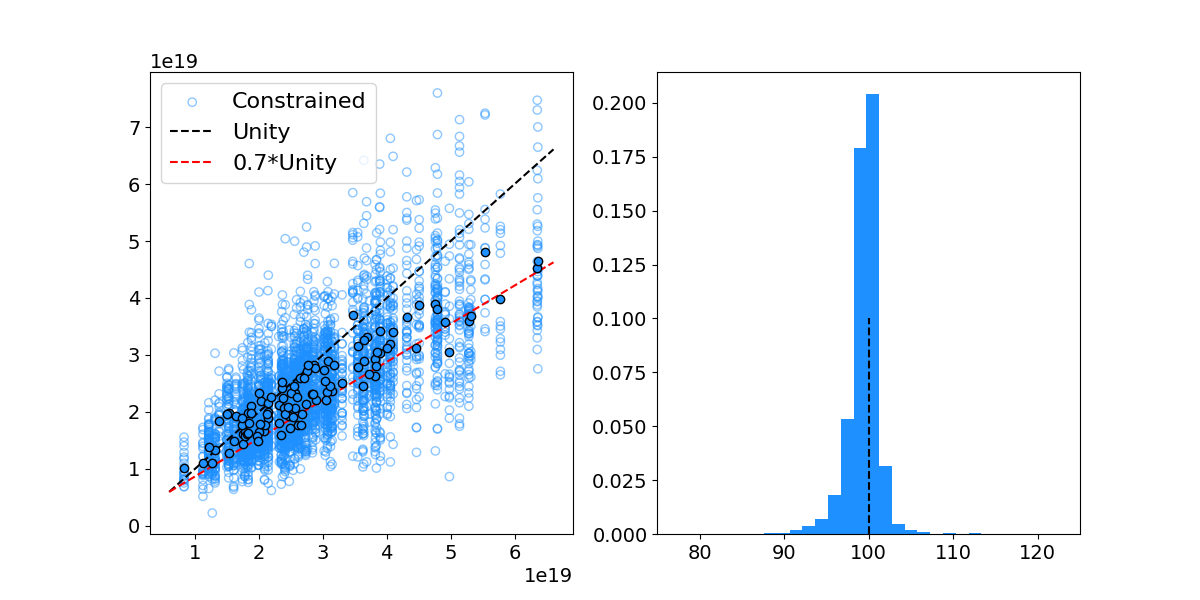

  0%|          | 0/77 [00:00<?, ?it/s]

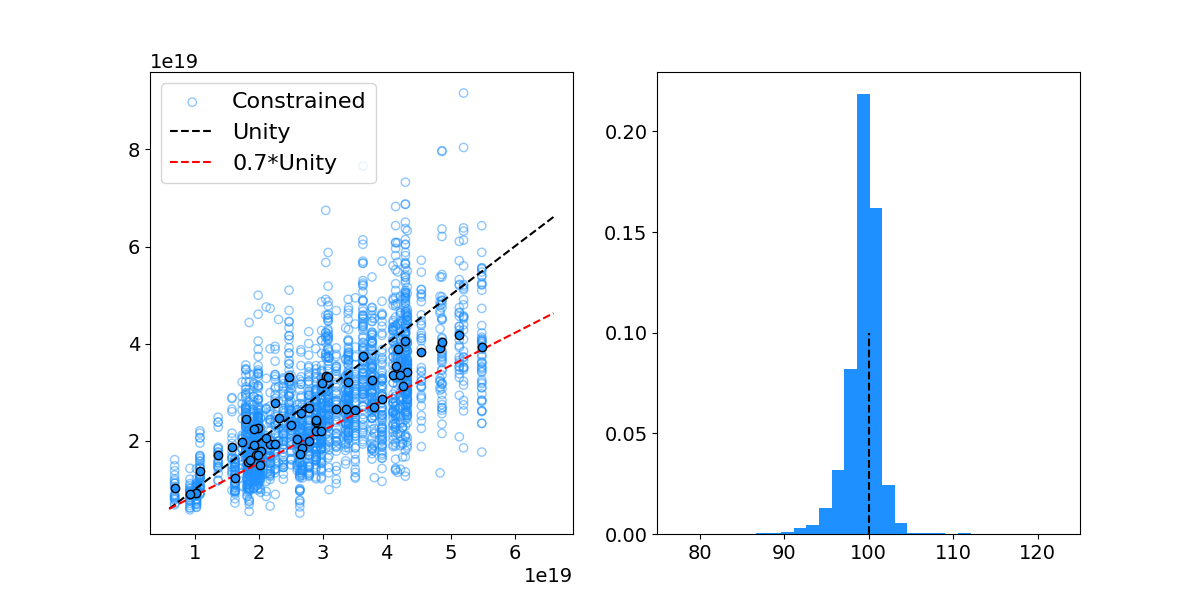

In [294]:
plt.close('all')
# 
# 
plot_against_lorenzo(train_nesep_tesep_tuple, train_new_pulse_idxs, train_pulses_ordered_set)
plot_against_lorenzo(val_nesep_tesep_tuple, val_new_pulse_idxs, val_pulses_ordered_set)
plot_against_lorenzo(test_nesep_tesep_tuple, test_new_pulse_idxs, test_pulses_ordered_set)

In [5]:
# Plot vs lorenzo! 

def plot_against_lorenzo(nesep_tesep_tuple, set_idxs, set_pulse_order, compare=False, reduce=True):
    
    set_neseps, set_neseps_nc, set_teseps, set_teseps_nc = nesep_tesep_tuple
    iterator = tqdm(enumerate(zip(set_idxs, set_pulse_order)), total=len(set_pulse_order))
    fig, axs = plt.subplots(1,2, figsize=(12, 6))
    for pulse, (pulse_idxs, pulse_number) in iterator:  
        if pulse == 2: 
            label_nc = 'Unconstrained'
            label = 'Constrained'
        else: 
            label = None
            label_nc = None
        if len(pulse_idxs) == 0: 
            continue
        # Find lorenzo values 
        JPDB_pulse = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == pulse_number]
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
        index_to_take_from = 0
        if len(JPDB_pulse) > 1: 
            print('There are multiple slices here for lorenzo value, .. have to pick one!')
        elif len(JPDB_pulse) < 1: 
            print('there seem to be no values here!')
            break
        lorenzo_nesep_exp, lorenzo_nesep_fit  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
     
        
        pulse_neseps, pulse_neseps_nc, pulse_teseps, pulse_teseps_nc = set_neseps[pulse_idxs], set_neseps_nc[pulse_idxs], set_teseps[pulse_idxs], set_teseps_nc[pulse_idxs]
        
        axs[0].scatter([1e19*lorenzo_nesep_fit]*len(pulse_neseps), pulse_neseps, facecolors='none', edgecolor='dodgerblue', label=label, alpha=0.5, zorder=0)
        axs[0].scatter(1e19*lorenzo_nesep_fit, pulse_neseps.mean(), color='dodgerblue', edgecolor=(0, 0, 0), zorder=10)
        
        if compare: 
            axs[0].scatter([1e19*lorenzo_nesep_fit]*len(pulse_neseps_nc), pulse_neseps_nc, facecolors='none', edgecolor='orange', label=label_nc, alpha=0.5, zorder=0)
            axs[0].scatter(1e19*lorenzo_nesep_fit, pulse_neseps_nc.mean(), color='orange', edgecolor=(0, 0, 0), zorder=10)
            
        
        
    axs[0].plot([1e19*min(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)']), 1e19*max(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)'])], [1e19*min(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)']), 1e19*max(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)'])], color='black', ls='--', label='Unity')
    axs[0].plot([1e19*min(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)']), 1e19*max(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)'])], [1e19*min(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)']), 0.7*1e19*max(PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)'])], color='red', ls='--', label='0.7*Unity')
    
    # axs[1].plot([min(pulse_teseps), max(pulse_teseps)], [100, 100], color='black', ls='--')
    if compare: 
        axs[1].hist(pulse_teseps_nc, bins=50,color='orange')
    not_nan = np.logical_and(np.invert(np.isnan(set_teseps)), np.invert(np.isnan(set_neseps)))
    axs[1].hist(set_teseps[not_nan], bins=75, density=True, color='dodgerblue')
    axs[1].set_xlim(75, 125)
    axs[1].vlines(100, 0, 0.1, ls='--', color='black')
    axs[0].legend()
    plt.show()
# plt.close('all')
# plot_against_lorenzo(test_nesep_tesep_tuple, test_new_pulse_idxs, test_pulses_ordered_set)

In [119]:
def find_neseps(pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks, pedestal_tops, pulse_number, n_samples=6000,  plotting=False, compare=True):
    # Free parameters for the normal distributions
    lbound_t, ubound_t = 0, 1000
    lbound_n, ubound_n = 0, 1e20
    
    # Free parameters for the tsep to mean around 
    lbound_tsep, ubound_tsep = 75, 125
    
    # Free parameter for SOL WIDTH 
    SOL_WIDTH = 0.02 # 2 cm
    
    neseps, teseps = np.zeros(len(pulse_profs)), np.zeros(len(pulse_profs))
    neseps_nc, teseps_nc = np.zeros(len(pulse_profs)), np.zeros(len(pulse_profs))
    pedestal_top_mean, pedestal_top_std = pedestal_tops.mean(),  pedestal_tops.std()
    if plotting: 
        fig = plt.subplots(2, 1, figsize=(16, 8), constained_layout=True)
        gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
        ax2 = fig.add_subplot(gs1[0])
        ax1 = fig.add_subplot(gs1[1])

        ax1.set_xlabel('$T_e$ [eV]')
        ax2.set_xlabel('$n_e$ [m$^{-3}$]')
        ax2.set_ylabel('PDF')
        ax1.set_ylabel('PDF')

        gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
        ax3 = fig.add_subplot(gs2[0])
        ax4 = fig.add_subplot(gs2[1])

        ax4.set_ylabel('$T_e$ [eV]')
        ax4.set_xlabel('HRTS Line of Sight [m]')
        ax3.set_ylabel('$n_e$ [m$^{-3}$]')
        
        axs = [ax3, ax4, ax1, ax2]
        
    
    for sl, (slice_profiles, slice_uncerts, slice_rmids, slice_masks, slice_pedestal_top) in enumerate(zip(pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks, pedestal_tops)):
        # If the slice lands outside the first standard deviation, then use the mean
        if abs(slice_pedestal_top - pedestal_top_mean) > pedestal_top_std: 
            filter_starting_point = pedestal_top_mean
        else: 
            filter_starting_point = slice_pedestal_top
        
        # Gaussian Filtering
               
        
        # Gather slice data  
        bool_mask = slice_masks > 0
        slice_te = slice_profiles[1]
        print(slice_te)
        
        slice_ne, slice_te = slice_profiles[0][bool_mask], slice_profiles[1][bool_mask]
        slice_ne_uncert, slice_te_uncert = slice_uncerts[0][bool_mask], slice_uncerts[1][bool_mask]
        slice_rmid = slice_rmids[bool_mask]
        
        bool_mask = np.logical_and(slice_rmid >= filter_starting_point, slice_rmid <= filter_starting_point + SOL_WIDTH)
        offset = 0.001
        while bool_mask.sum() < 2: 
            bool_mask = np.logical_and(slice_rmid >= filter_starting_point - offset, slice_rmid <= filter_starting_point + SOL_WIDTH + offset)
            offset += 0.0005
        
        while (slice_te[bool_mask] > 100).any() == False:
            # print('shit below')
            bool_mask = np.logical_and(slice_rmid >= filter_starting_point - offset, slice_rmid <= filter_starting_point + SOL_WIDTH)
            offset += 0.0005
            
        while (slice_te[bool_mask] < 100).any() == False:
            # print('shit above')
            bool_mask = np.logical_and(slice_rmid >= filter_starting_point - 0.5*offset, slice_rmid <= filter_starting_point + SOL_WIDTH + offset)
            offset += 0.0005
            
        slice_ne, slice_te = slice_ne[bool_mask], slice_te[bool_mask]
        slice_rmid = slice_rmid[bool_mask]
        
        print(slice_te)
        out = get_nearest_weighted_idx(100, slice_te)
        (w1, idx1), (w2, idx2) = out
        
        print('Last', out, slice_te[idx1], slice_te[idx2], w1*slice_te[idx1] + w2*slice_te[idx2] )
        
        
        if plotting: 
            axs[0].scatter(slice_rmid, slice_ne, color='dodgerblue')
            axs[1].scatter(slice_rmid, slice_te, color='orange')
            
        
    if plotting: 
        axs[0].set_ylim(-1e18, 1e20)
        axs[1].set_ylim(-50, 800)
        axs[0].hlines(neseps, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='Constrained')
        axs[0].hlines(neseps_nc, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='No-constraints')
        
        axs[1].hlines(teseps, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='Constrained')
        axs[1].hlines(teseps_nc, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='No-constraints')
        
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    return neseps, teseps, neseps_nc, teseps_nc

# 

In [64]:
def find_pedestal_tops(pulse_profs, pulse_rmids, pulse_masks, plotting = False) :
    
    # CHANGE: to nans? 
    pedestal_tops, pedestal_bottoms = np.zeros(len(pulse_profs)), np.zeros(len(pulse_profs))
    
    if plotting: 
        fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    for sl, (slice_profiles, slice_rmids, slice_masks) in enumerate(zip(pulse_profs, pulse_rmids, pulse_masks)):
        bool_mask = slice_masks > 0
        densities, temperatures, x_coords = slice_profiles[0][bool_mask], slice_profiles[1][bool_mask], slice_rmids[bool_mask]
        slice_pedestal_top, slice_pedestal_bottom = get_pedestal_top_for_slice(densities, x_coords)
        pedestal_tops[sl] = slice_pedestal_top
        pedestal_bottoms[sl] = slice_pedestal_bottom
    
        if plotting: 
            axs[0].scatter(x_coords, densities, color='dodgerblue')
            axs[1].scatter(x_coords, temperatures, color='orange')
            
            axs[0].vlines(slice_pedestal_top, 0, 1e20, color='black', ls='--',alpha=0.7)
            axs[1].vlines(slice_pedestal_top, 0, 500, color='black', ls='--',alpha=0.7)
            
            # axs[0].vlines(slice_pedestal_bottom, 0, 1e20, color='green', ls='--',alpha=0.7)
            # axs[1].vlines(slice_pedestal_bottom, 0, 500, color='green', ls='--',alpha=0.7)
            
    if plotting: 
        axs[0].set_ylim(-1e18, 1e20)
        axs[1].set_ylim(-50, 800)
        
        axs[0].vlines(pedestal_tops.mean(), 0, 1e20, color='red')
        axs[1].vlines(pedestal_tops.mean(), 0, 500, color='red')
        
        axs[0].vlines([pedestal_tops.mean() + pedestal_tops.std(), pedestal_tops.mean() - pedestal_tops.std()], 0, 1e20, color='magenta')
        axs[1].vlines([pedestal_tops.mean() + pedestal_tops.std(), pedestal_tops.mean() - pedestal_tops.std()], 0, 500, color='magenta')
        
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    return pedestal_tops
    


In [14]:
def find_neseps(pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks, pedestal_tops, pulse_number, n_samples=6000,  plotting=False, compare=True):
    # Free parameters for the normal distributions
    lbound_t, ubound_t = 0, 1000
    lbound_n, ubound_n = 0, 1e20
    
    # Free parameters for the tsep to mean around 
    lbound_tsep, ubound_tsep = 75, 125
    
    # Free parameter for SOL WIDTH 
    SOL_WIDTH = 0.02 # 2 cm
    
    neseps, teseps = np.zeros(len(pulse_profs)), np.zeros(len(pulse_profs))
    neseps_nc, teseps_nc = np.zeros(len(pulse_profs)), np.zeros(len(pulse_profs))
    pedestal_top_mean, pedestal_top_std = pedestal_tops.mean(),  pedestal_tops.std()
    if plotting: 
        fig = plt.subplots(2, 1, figsize=(16, 8), constained_layout=True)
        gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
        ax2 = fig.add_subplot(gs1[0])
        ax1 = fig.add_subplot(gs1[1])

        ax1.set_xlabel('$T_e$ [eV]')
        ax2.set_xlabel('$n_e$ [m$^{-3}$]')
        ax2.set_ylabel('PDF')
        ax1.set_ylabel('PDF')

        gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
        ax3 = fig.add_subplot(gs2[0])
        ax4 = fig.add_subplot(gs2[1])

        ax4.set_ylabel('$T_e$ [eV]')
        ax4.set_xlabel('HRTS Line of Sight [m]')
        ax3.set_ylabel('$n_e$ [m$^{-3}$]')
        
        axs = [ax3, ax4, ax1, ax2]
        
    
    for sl, (slice_profiles, slice_uncerts, slice_rmids, slice_masks, slice_pedestal_top) in enumerate(zip(pulse_profs, pulse_uncerts, pulse_rmids, pulse_masks, pedestal_tops)):
        # If the slice lands outside the first standard deviation, then use the mean
        if abs(slice_pedestal_top - pedestal_top_mean) > pedestal_top_std: 
            filter_starting_point = pedestal_top_mean
        else: 
            filter_starting_point = slice_pedestal_top
        
        # Gaussian Filtering
               
        
        # Gather slice data  
        bool_mask = slice_masks > 0
        slice_ne, slice_te = slice_profiles[0][bool_mask], slice_profiles[1][bool_mask]
        slice_ne_uncert, slice_te_uncert = slice_uncerts[0][bool_mask], slice_uncerts[1][bool_mask]
        slice_rmid = slice_rmids[bool_mask]
        
        
        # To compare with the constraints via the pedestal top + 2cm, we do some without
        if compare:
            tes_gaussians_no_constraints = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, n_samples) for mu, var in zip(slice_te, slice_te_uncert)])
            nes_gaussians_no_constraints = np.array([truncnorm.rvs((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, n_samples) for mu, var in zip(slice_ne, slice_ne_uncert)])

            seperatrix_locations_no_constraints = np.logical_and(tes_gaussians_no_constraints >= lbound_tsep, tes_gaussians_no_constraints <= ubound_tsep)
            tesep_in_separatrix_no_constraints = tes_gaussians_no_constraints[seperatrix_locations_no_constraints]
            nes_in_separatrix_no_constraints = nes_gaussians_no_constraints[seperatrix_locations_no_constraints]

            if len(tesep_in_separatrix_no_constraints) == 0: 
                print(pulse_number, 'NC: Found no T values between 80 and 120! CONSIDER REDOING')
                neseps_nc[sl], teseps_nc[sl] = np.nan, np.nan
            else:
                neseps_nc[sl], teseps_nc[sl] = nes_in_separatrix_no_constraints.mean(), tesep_in_separatrix_no_constraints.mean()

        # Now with the constraints 
        
        SOL_mask = np.logical_and(slice_rmid >= filter_starting_point, slice_rmid <= filter_starting_point + SOL_WIDTH)
        
        
        if SOL_mask.sum() == 0: 
            print(pulse_number, 'No points found in the SOL width defined... extending boundrary')
            SOL_mask = np.logical_and(slice_rmid >= filter_starting_point - 0.02, slice_rmid <= filter_starting_point + SOL_WIDTH + 0.01)
        if SOL_mask.sum() == 0: 
            print('Still nothing')    
        slice_ne_SOL, slice_te_SOL, slice_ne_uncert_SOL, slice_te_uncert_SOL, slice_rmid_SOL = slice_ne[SOL_mask], slice_te[SOL_mask], slice_ne_uncert[SOL_mask], slice_te_uncert[SOL_mask], slice_rmid[SOL_mask]
        
        
        
        tes_gaussians = np.array([signal.fftconvolve(truncnorm.pdf((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, n_samples), normal_dist = norm(loc=100, scale=5).pdf() , 'same') for mu, var in zip(slice_te_SOL, slice_te_uncert_SOL)])
        nes_gaussians = np.array([truncnorm((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, n_samples) for mu, var in zip(slice_ne_SOL, slice_ne_uncert_SOL)])
        
        seperatrix_locations = np.logical_and(tes_gaussians >= lbound_tsep, tes_gaussians <= ubound_tsep)
        tesep_in_separatrix = tes_gaussians[seperatrix_locations]
        nes_in_separatrix = nes_gaussians[seperatrix_locations]
        
        if len(tesep_in_separatrix) == 0: 
            print(pulse_number, 'MASKED: Found no T values between 80 and 120... extending space')
            
            neseps[sl], teseps[sl] = np.nan, np.nan
        else:
            neseps[sl], teseps[sl] = nes_in_separatrix.mean(), tesep_in_separatrix.mean()
            """
            if tesep_in_separatrix.mean() < 100: 
                SOL_mask = np.logical_and(slice_rmid >= filter_starting_point - 0.01, slice_rmid <= filter_starting_point + SOL_WIDTH)
        
                slice_ne_SOL, slice_te_SOL, slice_ne_uncert_SOL, slice_te_uncert_SOL, slice_rmid_SOL = slice_ne[SOL_mask], slice_te[SOL_mask], slice_ne_uncert[SOL_mask], slice_te_uncert[SOL_mask], slice_rmid[SOL_mask]
                tes_gaussians = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, n_samples) for mu, var in zip(slice_te_SOL, slice_te_uncert_SOL)])
                nes_gaussians = np.array([truncnorm.rvs((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, n_samples) for mu, var in zip(slice_ne_SOL, slice_ne_uncert_SOL)])

                seperatrix_locations = np.logical_and(tes_gaussians >= lbound_tsep, tes_gaussians <= ubound_tsep + 20)
                tesep_in_separatrix = tes_gaussians[seperatrix_locations]
                nes_in_separatrix = nes_gaussians[seperatrix_locations]
            elif tesep_in_separatrix.mean() > 100: 
                SOL_mask = np.logical_and(slice_rmid >= filter_starting_point, slice_rmid <= filter_starting_point + SOL_WIDTH + 0.01)
        
                slice_ne_SOL, slice_te_SOL, slice_ne_uncert_SOL, slice_te_uncert_SOL, slice_rmid_SOL = slice_ne[SOL_mask], slice_te[SOL_mask], slice_ne_uncert[SOL_mask], slice_te_uncert[SOL_mask], slice_rmid[SOL_mask]
                tes_gaussians = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, n_samples) for mu, var in zip(slice_te_SOL, slice_te_uncert_SOL)])
                nes_gaussians = np.array([truncnorm.rvs((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, n_samples) for mu, var in zip(slice_ne_SOL, slice_ne_uncert_SOL)])

                seperatrix_locations = np.logical_and(tes_gaussians >= lbound_tsep, tes_gaussians <= ubound_tsep + 20)
                tesep_in_separatrix = tes_gaussians[seperatrix_locations]
                nes_in_separatrix = nes_gaussians[seperatrix_locations]
            """
        
        if plotting: 
            axs[0].scatter(slice_rmid, slice_ne, color='dodgerblue')
            axs[1].scatter(slice_rmid, slice_te, color='orange')
            
        
    if plotting: 
        axs[0].set_ylim(-1e18, 1e20)
        axs[1].set_ylim(-50, 800)
        axs[0].hlines(neseps, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='Constrained')
        axs[0].hlines(neseps_nc, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='No-constraints')
        
        axs[1].hlines(teseps, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='Constrained')
        axs[1].hlines(teseps_nc, pedestal_top_mean, pedestal_top_mean + 0.02, color='red', ls='--', label='No-constraints')
        
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    return neseps, teseps, neseps_nc, teseps_nc

# 

In [ ]:
train_ids[train_new_pulse_idxs[p]], train_pulses_ordered_set[p],  train_elm_percentages[train_new_pulse_idxs[p]], train_new_pulse_idxs[p],#  